# Are commission rates variable across dates?

In [ ]:
from __future__ import annotations

from datetime import date
from typing import Dict, List, Mapping

import pandas as pd

from expedia.client import ExpediaClient
from expedia.geo_helpers import circle_polygon_geojson

# -------------------------------------------------------------------
# Inputs
# -------------------------------------------------------------------
LATITUDE = 51.50472006812112
LONGITUDE = -0.11104376771283224
RADIUS_KM = 6
CHECKIN = date(2025, 11, 20)
CHECKOUT = date(2025, 11, 22)

OCCUPANCY = 2 
occupancy_key = str(OCCUPANCY)

RATE_TYPES = (
    # "mkt_prepay", 
    "priv_pkg", 
    "pub_prepay"
)

BATCH_SIZE = 250                  

# -------------------------------------------------------------------
# Fetch property ids in the search circle
# -------------------------------------------------------------------
client = ExpediaClient.from_env()

polygon = circle_polygon_geojson(
    center_lat=LATITUDE,
    center_lon=LONGITUDE,
    radius_m=RADIUS_KM * 1000,
)

property_ids = list(
    client.search_geography(
        polygon,
        include="property_ids",
        supply_source="expedia",
        checkin=str(CHECKIN),
        checkout=str(CHECKOUT),
    )
)
print(len(property_ids))


3855


In [8]:

availability_by_rate: Dict[str, Dict[str, Mapping[str, object]]] = {rt: {} for rt in RATE_TYPES}
property_summaries: Dict[str, Mapping[str, object]] = {}

def availability_fetch_factory(rate_type: str):
    def _fetch(batch: List[str]) -> Mapping[str, object]:
        return client.fetch_availability(
            batch,
            checkin=str(CHECKIN),
            checkout=str(CHECKOUT),
            occupancy=occupancy_key,
            rate_type=rate_type,
            rate_plan_count=4,  # grab a few plans so we see more than the absolute cheapest
            # rate_options=["member"],
        )

    return _fetch


def fetch_summaries(batch: List[str]) -> Mapping[str, object]:
    return client.fetch_property_summaries(
        batch,
        includes=("name", "address", "location", "statistics", "category"),
    )


jobs = [(availability_fetch_factory(rt), availability_by_rate[rt]) for rt in RATE_TYPES]
jobs.append((fetch_summaries, property_summaries))

client.run_batched(property_ids, jobs=jobs, batch_size=BATCH_SIZE)


In [54]:
p_id = property_ids[2]

rate_types = ["mkt_prepay", "pub_prepay", "priv_pkg"]
rate_info = [
    'exclusive',
    'inclusive_strikethrough',
    'property_inclusive_strikethrough',
    'gross_profit',
    'strikethrough',
    'property_inclusive',
    'inclusive',
    'marketing_fee'
]

def _get_room_name(rate_type):
    return availability_by_rate[rate_type][p_id]["rooms"][0]["room_name"]

def _get_rate_value(rate_type, rate_key):
    rate_info = availability_by_rate[rate_type][p_id]["rooms"][0]["rates"][0]["occupancy_pricing"]['2']['totals'].get(rate_key, {}) or None
    if rate_info:
        return rate_info["request_currency"]["value"] 
    else: return None

df = pd.DataFrame({
    "rate_types": rate_types,
    "rooms": [_get_room_name(rate_type) for rate_type in rate_types]
    })

for rate_key in rate_info:
    df[rate_key] = [_get_rate_value(rate_type, rate_key) for rate_type in rate_types]

df["comm %"] = round(df["marketing_fee"].astype(float) / df["property_inclusive"].astype(float) * 100, 2)
df

,rate_types,rooms,exclusive,inclusive_strikethrough,property_inclusive_strikethrough,gross_profit,strikethrough,property_inclusive,inclusive,marketing_fee,comm %
0,mkt_prepay,"Room, 1 Queen Bed (General Admission)",693.80,None,None,None,None,832.56,832.56,None,NaN
1,pub_prepay,"Room, 1 Queen Bed (General Admission)",693.80,None,None,101.62,None,832.56,832.56,63.00,7.57
2,priv_pkg,"Room, 1 Queen Bed (General Admission)",757.57,None,None,141.61,None,896.21,896.21,87.80,9.80


In [10]:
keep_ids = []
for pid in property_ids:
    summary = property_summaries.get(pid, {})
    stats = summary.get("statistics") or {}
    rooms = stats.get("52", {}).get("value")
    category = summary.get("category").get("name")

    try:
        room_count = int(rooms)
    except (TypeError, ValueError):
        room_count = None

    if room_count is not None and room_count >= 10 and category.lower() == "hotel":
        keep_ids.append(pid)
    else:
        # Drop any cached data quietly; missing keys are fine
        property_summaries.pop(pid, None)
        for rate_type in availability_by_rate:
            availability_by_rate[rate_type].pop(pid, None)

print(f"{len(keep_ids)} of {len(property_ids)} kept")
property_ids = keep_ids


753 of 3854 kept


In [56]:
def room_key(room: Mapping[str, object]) -> str | None:
    # Expedia usually includes an explicit room id; fall back to name if needed.
    return room.get("id") or room.get("room_name")

def first_rate(room: Mapping[str, object]) -> Mapping[str, object]:
    rates = room.get("rates") or []
    return rates[0] if rates else {}

def get_total(rate: Mapping[str, object], total_key: str) -> float | None:
    occupancy_pricing = rate.get("occupancy_pricing") or {}
    occ_block = occupancy_pricing.get(occupancy_key)
    if occ_block is None and occupancy_pricing:
        occ_block = next(iter(occupancy_pricing.values()))
    if not occ_block:
        return None
    total = (occ_block.get("totals") or {}).get(total_key) or {}
    value = (total.get("request_currency") or {}).get("value")
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


rows = []
for pid in property_ids:
    summary = property_summaries.get(pid, {})
    public_rooms = {
        room_key(room): room
        for room in (availability_by_rate["pub_prepay"].get(pid, {}) or {}).get("rooms", []) or []
        if room_key(room)
    }
    private_rooms = {
        room_key(room): room
        for room in (availability_by_rate["priv_pkg"].get(pid, {}) or {}).get("rooms", []) or []
        if room_key(room)
    }

    for key in sorted(set(public_rooms) & set(private_rooms)):
        pub_room = public_rooms[key]
        priv_room = private_rooms[key]

        pub_rate = first_rate(pub_room)
        priv_rate = first_rate(priv_room)

        rows.append(
            {
                "Property ID": pid,
                "Hotel name": summary.get("name") or summary.get("property_name"),
                "Rooms": summary.get("statistics", {}).get("52", {}).get("value"),
                "cat": summary.get("category")["name"],
                "Room ID": key,
                "Room name": pub_room.get("room_name"),
                "Room name priv": priv_room.get("room_name"),
                "Public Available": pub_rate.get("available_rooms"),
                "Private Available": priv_rate.get("available_rooms"),
                "Public Rate": get_total(pub_rate, "inclusive"),
                "Private Rate": get_total(priv_rate, "inclusive"),
                "Public Commission": get_total(pub_rate, "marketing_fee"),
                "Private Commission": get_total(priv_rate, "marketing_fee"),
            }
        )

df = pd.DataFrame(rows)
df2 = df.copy()
df2.to_csv("rates_report.csv", index=False)
print(len(df))
df.head()

1958


,Property ID,Hotel name,Rooms,cat,Room ID,Room name,Room name priv,Public Available,Private Available,Public Rate,Private Rate,Public Commission,Private Commission
0,1,Treehouse Hotel London,95,Hotel,213308699,"Room, 1 King Bed (Lookout)","Room, 1 King Bed (Lookout)",5,5,1179.43,1166.66,109.32,101.65
1,1,Treehouse Hotel London,95,Hotel,213309086,"Room, 1 King Bed (Skyline)","Room, 1 King Bed (Skyline)",10,10,1177.59,1164.83,109.15,101.48
2,1,Treehouse Hotel London,95,Hotel,213309087,"Room, 1 Queen Bed (Skyline)","Room, 1 Queen Bed (Skyline)",5,5,1160.04,1147.48,107.51,99.96
3,1,Treehouse Hotel London,95,Hotel,213310174,"Room, 1 King Bed (Fort)","Room, 1 King Bed (Fort)",1,1,1048.29,1036.93,97.16,90.34
4,100012096,Hyde London City - St Paul’s,111,Hotel,323740879,"Room, 1 Queen Bed (General Admission. More space)","Room, 1 Queen Bed (General Admission. More space)",4999,4999,856.30,844.18,65.05,82.70


In [ ]:
from datetime import timedelta
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Time-series chart parameters
# -------------------------------------------------------------------
PROPERTY_SLICE = property_ids
DAYS_AHEAD = 180
STAY_NIGHTS = 1
TIME_STEP_DAYS = 1

slice_summaries = {
    pid: property_summaries.get(pid)
    or client.fetch_property_summaries([pid], includes=("name", "property_name")).get(pid, {})
    for pid in PROPERTY_SLICE
}

def availability_fetch_factory_for_window(rate_type: str, checkin_date: date, checkout_date: date):
    def _fetch(batch: List[str]) -> Mapping[str, object]:
        return client.fetch_availability(
            batch,
            checkin=str(checkin_date),
            checkout=str(checkout_date),
            occupancy=occupancy_key,
            rate_type=rate_type,
            rate_plan_count=4,
        )
    return _fetch

def build_room_index(payload: Mapping[str, object]) -> Dict[str, Mapping[str, object]]:
    rooms = (payload or {}).get("rooms", []) or []
    return {room_key(room): room for room in rooms if room_key(room)}

time_series_rows: List[Dict[str, object]] = []

for offset in range(0, DAYS_AHEAD, TIME_STEP_DAYS):
    
    checkin_date = CHECKIN + timedelta(days=offset)
    checkout_date = checkin_date + timedelta(days=STAY_NIGHTS)
    print(f"calling {checkin_date}")
    availability_window = {rt: {} for rt in RATE_TYPES}
    jobs = [
        (
            availability_fetch_factory_for_window(rt, checkin_date, checkout_date),
            availability_window[rt],
        )
        for rt in RATE_TYPES
    ]
    client.run_batched(PROPERTY_SLICE, jobs=jobs, batch_size=BATCH_SIZE)

    for pid in PROPERTY_SLICE:
        summary = slice_summaries.get(pid, {})
        public_rooms = build_room_index(availability_window["mkt_prepay"].get(pid, {}))
        private_rooms = build_room_index(availability_window["priv_pkg"].get(pid, {}))

        for key in sorted(set(public_rooms) & set(private_rooms)):
            pub_room = public_rooms[key]
            priv_room = private_rooms[key]

            pub_rate = first_rate(pub_room)
            priv_rate = first_rate(priv_room)

            time_series_rows.append(
                {
                    "Property ID": pid,
                    "Hotel name": summary.get("name") or summary.get("property_name"),
                    "Rooms": summary.get("statistics", {}).get("52", {}).get("value"),
                    "Room ID": key,
                    "Room name": pub_room.get("room_name"),
                    "Room name priv": priv_room.get("room_name"),
                    "Public Available": pub_rate.get("available_rooms"),
                    "Private Available": priv_rate.get("available_rooms"),
                    "Public Rate": get_total(pub_rate, "inclusive"),
                    "Private Rate": get_total(priv_rate, "inclusive"),
                    "Public Commission": get_total(pub_rate, "marketing_fee"),
                    "Private Commission": get_total(priv_rate, "marketing_fee"),
                }
            )


time_series_df = pd.DataFrame(time_series_rows)

if time_series_df.empty:
    print("No overlapping room data for the chosen properties/time horizon.")
else:
    daily_avg = (
        time_series_df.groupby("Check-in")[["Public Rate", "Private Rate", "Private Commission"]]
        .mean()
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    for column, color in zip(
        ["Public Rate", "Private Rate", "Private Commission"],
        ["tab:blue", "tab:orange", "tab:green"],
    ):
        plt.plot(
            daily_avg.index,
            daily_avg[column],
            marker="o",
            color=color,
            label=f"Average {column}",
        )

    plt.title(f"Average Rates vs. Check-in Date ({len(PROPERTY_SLICE)} properties, {STAY_NIGHTS}-night stay)")
    plt.xlabel("Check-in date")
    plt.ylabel("Average amount (request currency)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


calling 2025-11-20
calling 2025-11-21
calling 2025-11-22
calling 2025-11-23
calling 2025-11-24
calling 2025-11-25
calling 2025-11-26
calling 2025-11-27
calling 2025-11-28
calling 2025-11-29
calling 2025-11-30
calling 2025-12-01
calling 2025-12-02
calling 2025-12-03
calling 2025-12-04
calling 2025-12-05
calling 2025-12-06
calling 2025-12-07
calling 2025-12-08
calling 2025-12-09
calling 2025-12-10
calling 2025-12-11
calling 2025-12-12
calling 2025-12-13
calling 2025-12-14
calling 2025-12-15
calling 2025-12-16
calling 2025-12-17
calling 2025-12-18
calling 2025-12-19
calling 2025-12-20
calling 2025-12-21
calling 2025-12-22
calling 2025-12-23
calling 2025-12-24
calling 2025-12-25
calling 2025-12-26
calling 2025-12-27
calling 2025-12-28
calling 2025-12-29
calling 2025-12-30
calling 2025-12-31
calling 2026-01-01
calling 2026-01-02
calling 2026-01-03
calling 2026-01-04
calling 2026-01-05
calling 2026-01-06
calling 2026-01-07
calling 2026-01-08
calling 2026-01-09
calling 2026-01-10
calling 2026

In [ ]:
daily_avg["Priv comm%"] = round(daily_avg["Private Commission"] / daily_avg["Private Rate"] * 100, 2)
daily_avg["Pub comm%"] = round(daily_avg["Public Commission"] / daily_avg["Public Rate"] * 100, 2)
daily_avg["Discount"] = daily_avg["Public Rate"] - daily_avg["Private Rate"]
daily_avg["Discount %"] = 1 - (daily_avg["Private Rate"] / daily_avg["Public Rate"])

time_series_df.to_csv("property_averages.csv")
daily_avg.to_csv("daily_average.csv")

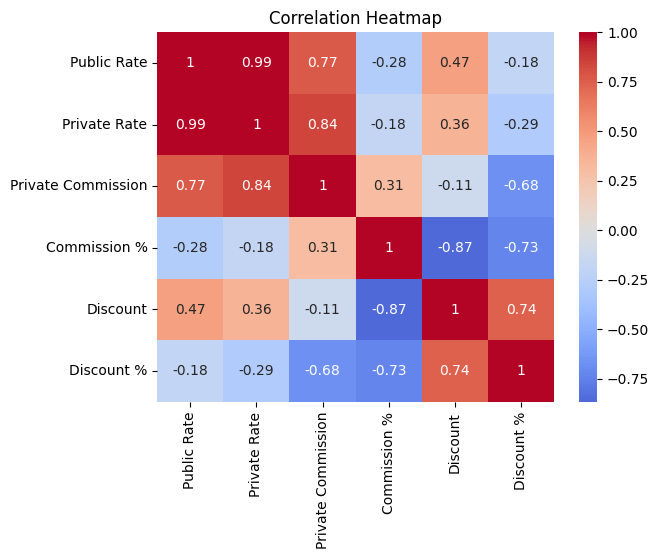

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

corr = daily_avg.corr(method="spearman")

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:

availability_by_rate: Dict[str, Dict[str, Mapping[str, object]]] = {rt: {} for rt in RATE_TYPES}
property_summaries: Dict[str, Mapping[str, object]] = {}

def availability_fetch_factory(rate_type: str):
    def _fetch(batch: List[str]) -> Mapping[str, object]:
        return client.fetch_availability(
            batch,
            checkin=str(CHECKIN),
            checkout=str(CHECKOUT),
            occupancy=occupancy_key,
            rate_type=rate_type,
            rate_plan_count=4,  # grab a few plans so we see more than the absolute cheapest
            rate_op
        )

    return _fetch


def fetch_summaries(batch: List[str]) -> Mapping[str, object]:
    return client.fetch_property_summaries(
        batch,
        includes=("name", "address", "location", "statistics", "category"),
    )


jobs = [(availability_fetch_factory(rt), availability_by_rate[rt]) for rt in RATE_TYPES]
jobs.append((fetch_summaries, property_summaries))

client.run_batched(property_ids, jobs=jobs, batch_size=BATCH_SIZE)